# Cat vs Dog Classification using CNN

In this notebook, we will be training an image classifier using a Convolutional Neural Network (CNN) to classify images of cats and dogs. The images used here are from various datasets in Kaggle and the model will be trained using the `tensorflow` and `keras` libraries.

This is a very simple image processing project, wherin the model just scans every image looking for patterns and isn't given any indication on where to look or any boundaries of the subject in the image

**NOTE**: This notebook, should you choose to try it for yourself, will take a pretty long time to run on a regular CPU so I would recommend using a dedicated GPU for this task.

## Notebook Initialization

In [1]:
import tensorflow as tf
import os

We will be starting off by limiting the GPUs from using all of the VRAM to avoid any memory issues. 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Image Extraction and Processing

We start off by going through our image dataset and removing files that are not in image specific formats.  

In [3]:
import imghdr

data_dir = 'data'
img_exts = ['jpg', 'jpeg', 'png', 'bmp']

for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, img)

        img_type = imghdr.what(img_path)
        if img_type not in img_exts:
            os.remove(img_path)
            print(f'Removed image {img_path}')

Next we convert the directory of images into a dataset of numpy arrays and also scale the pixel values to be between 0 and 1 using a map function. Scaling the pixel values is important as it helps the model to converge faster and hence improves overall performance. In this step all images are also resized to a standard size of 255x255 pixels.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory(data_dir)
scaled_data = data.map(lambda x, y: (x/255, y))

Found 30573 files belonging to 2 classes.


We just visualize the said images in a grid to see if the images are loaded correctly and if the scaling has been done properly.

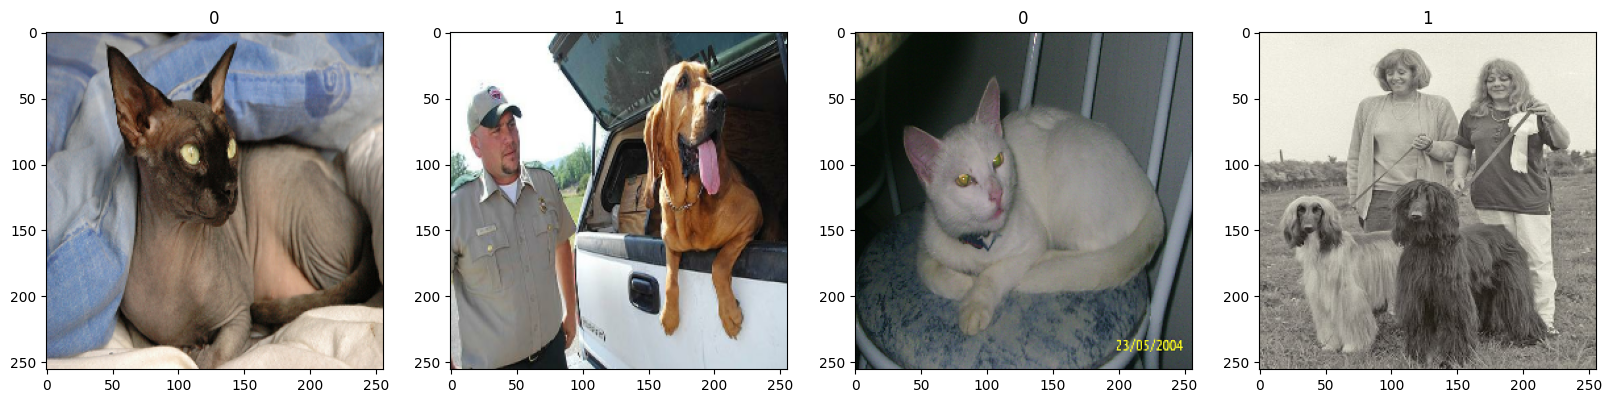

In [5]:
batch = scaled_data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

As we can see from the above grid, all the images are loaded correctly and the class 1 images are of dogs and class 0 images are of cats.

## Model Building

Now we split the scaled dataset into training, validation and testing sets. We will use 70% of the data for training, 20% for validation and 10% for testing.

In [6]:
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.2)
test_size = int(len(scaled_data) * 0.1) + 1

train_data = scaled_data.take(train_size)
val_data = scaled_data.skip(train_size).take(val_size)
test_data = scaled_data.skip(train_size + val_size).take(test_size)

Now we will build the CNN model using the `keras` library. We use a Sequential model with 3 Convolutional layers, 3 Max Pooling layers and 2 Dense layers. We also use Dropout layers in between to avoid overfitting of data. We use the `relu` activation function for the convolutional layers and the `sigmoid` activation function for the output layer to give a single output between 0 and 1.

Finally we compile the model using the `adam` optimizer and the `binary_crossentropy` loss function.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

Next we define a callback to get insights into the training and validation loss and accuracy. We then train the model using the `fit` method and the training and validation datasets.

In [8]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train_data, epochs=15, validation_data=val_data,
                 callbacks=tensorboard_callback)

Epoch 1/15
669/669 [==============================] - 126s 182ms/step - loss: 0.6555 - accuracy: 0.6713 - val_loss: 0.6225 - val_accuracy: 0.6692
Epoch 2/15
669/669 [==============================] - 60s 90ms/step - loss: 0.5893 - accuracy: 0.6832 - val_loss: 0.5920 - val_accuracy: 0.7065
Epoch 3/15
669/669 [==============================] - 58s 87ms/step - loss: 0.5557 - accuracy: 0.7111 - val_loss: 0.5351 - val_accuracy: 0.7325
Epoch 4/15
669/669 [==============================] - 59s 88ms/step - loss: 0.5127 - accuracy: 0.7441 - val_loss: 0.4766 - val_accuracy: 0.7688
Epoch 5/15
669/669 [==============================] - 59s 87ms/step - loss: 0.4382 - accuracy: 0.7967 - val_loss: 0.4344 - val_accuracy: 0.8056
Epoch 6/15
669/669 [==============================] - 60s 90ms/step - loss: 0.3782 - accuracy: 0.8327 - val_loss: 0.3986 - val_accuracy: 0.8104
Epoch 7/15
669/669 [==============================] - 61s 91ms/step - loss: 0.3292 - accuracy: 0.8620 - val_loss: 0.3420 - val_accurac

After training is completed we plot the training and validation loss to see how the model performed. Ideally the training and validation loss should be close to each other and should be decreasing over time.

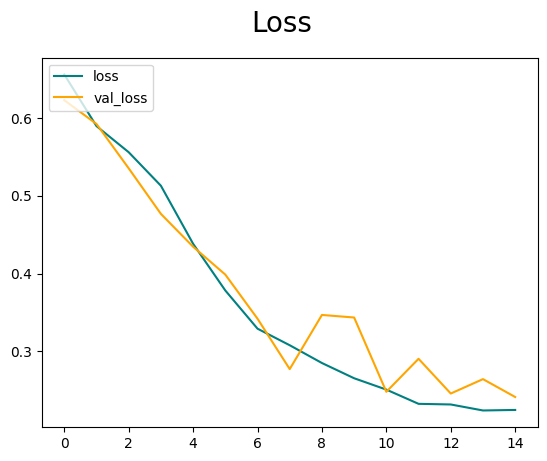

In [9]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Model Evaluation

Finally we evaluate the model using the test dataset and print the accuracy, precision and recall of the model.

In [10]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

print(f'Precision: {precision.result().numpy()} \nRecall: {recall.result().numpy()} \nAccuracy: {accuracy.result().numpy()}')

Precision: 0.8928733468055725 
Recall: 0.9595121741294861 
Accuracy: 0.895512580871582


Just to visually test the model, we will also predict the class of a few images not from the datasets and plot the images with their predicted class.

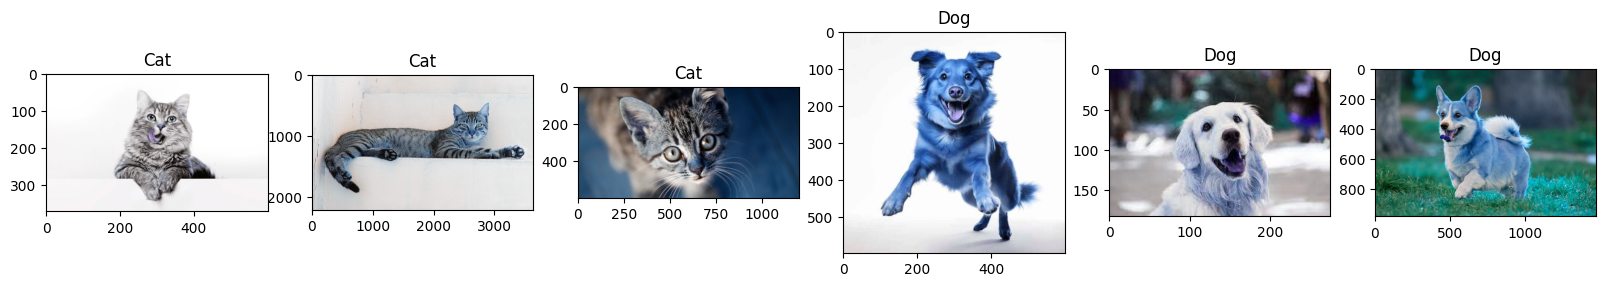

In [11]:
import cv2

fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, sample_img in enumerate(os.listdir('sample_images')):
    img = cv2.imread(os.path.join('sample_images', sample_img))
    scaled_img = tf.image.resize(img, (256, 256))
    scaled_img = np.expand_dims(scaled_img/255, 0)
    predict = model.predict(scaled_img, verbose=0)
    
    ax[idx].imshow(img)
    if predict > 0.5:
        ax[idx].title.set_text('Dog')
    else:
        ax[idx].title.set_text('Cat')

Finally we export the model to use in other applications.

In [12]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'catdogclassifier.h5'))

## Result

As we can see above the model has a fairly good accuracy for a simple CNN model and even in the sample images the model is able to predict the class of the images correctly. This is a good start for a simple image classification model and can be further improved by using more complex models and more data.